# GR5074: Projects in Advanced Machine Learning

## 1. Introduction

The COVID-19 pandemic highlighted the need for rapid and accurate diagnostic tools. Chest X-ray imaging has been a crucial tool for diagnosing lung infections, including COVID-19. This project aims to build predictive models to classify chest X-ray images into three categories: **COVID-19**, **Normal**, and **Viral Pneumonia**.

## 2. Dataset Visualization

### 2.1 Extracting and Preprocessing Images

We use the **COVID-19 Radiography Dataset**, which contains chest X-ray images categorized into three classes. For preprocessing:

- **Resizing**: Images are resized to 192x192 pixels.
- **Normalization**: Pixel values are normalized to the range [0, 1].
- **Balancing**: Each category is balanced to have an equal number of images (1,344 per class).

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
  inflating: COVID-19_Rad

In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import pickle
import warnings

warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed_value = 42  # Choose any integer
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Define base path and categories
base_path = "COVID-19_Radiography_Dataset"
categories = ["COVID/images", "Normal/images", "Viral Pneumonia/images"]

# Extract filenames
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

# Ensure equal number of images per class
fnames[0] = fnames[0][0:1344]
fnames[1] = fnames[1][0:1344]
fnames[2] = fnames[2][0:1344]


# Preprocessing function
def preprocessor(img_path):
    img = Image.open(img_path).convert("RGB").resize((192, 192))
    img = np.array(img).astype(np.float32) / 255.0
    return img


# Load images and labels
images = []
labels = []

for idx, files in enumerate(fnames):
    for file in files:
        images.append(preprocessor(file))
        labels.append(idx)

### 2.2 Visualizing Sample Images from Each Category

Below are sample images from each category:

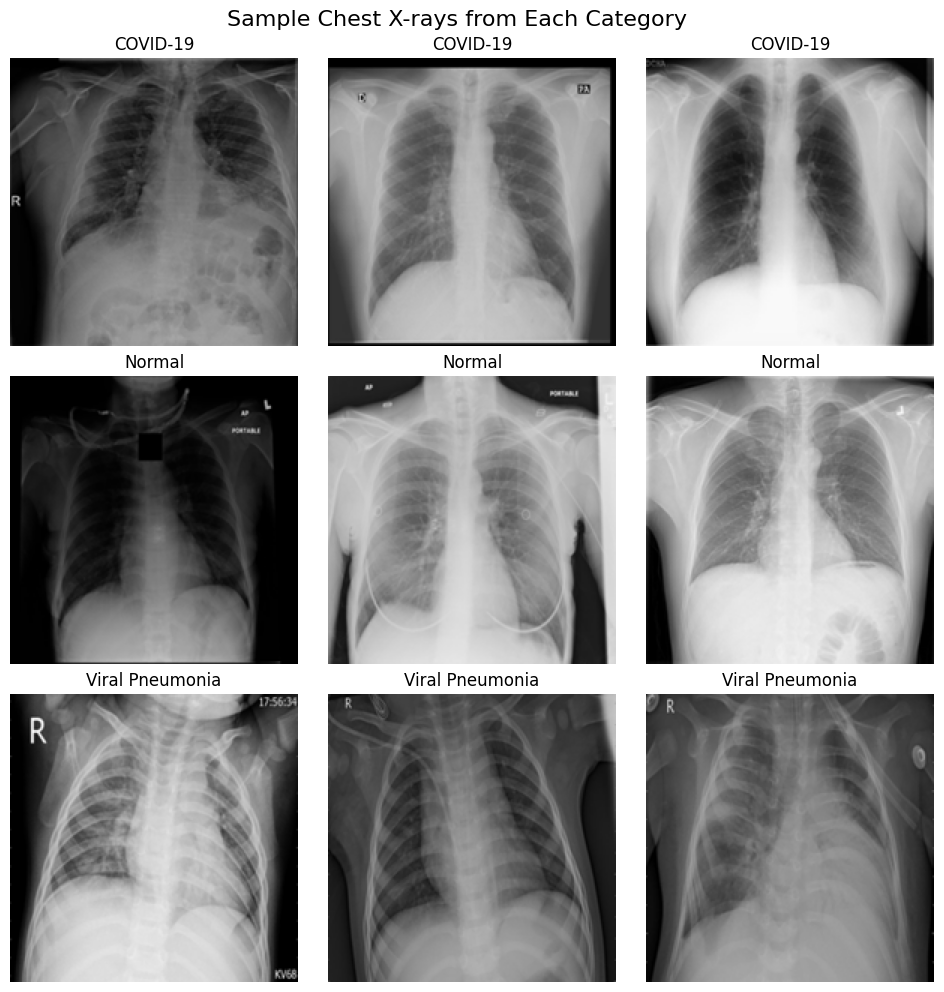

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

random.seed(42)
covid_samples = [preprocessor(fnames[0][i]) for i in random.sample(range(len(fnames[0])), 3)]
normal_samples = [preprocessor(fnames[1][i]) for i in random.sample(range(len(fnames[1])), 3)]
pneumonia_samples = [preprocessor(fnames[2][i]) for i in random.sample(range(len(fnames[2])), 3)]

fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.3)

sample_images = covid_samples + normal_samples + pneumonia_samples
titles = ["COVID-19"] * 3 + ["Normal"] * 3 + ["Viral Pneumonia"] * 3

for ax, im, title in zip(grid, sample_images, titles):
    ax.imshow(im)
    ax.set_title(title, fontsize=12)
    ax.axis("off")

plt.suptitle("Sample Chest X-rays from Each Category", fontsize=16, y=0.92)
plt.show()

## 3. Dataset Discussion

The **COVID-19 Radiography Dataset** provides chest X-ray images across three classes, each with 1,344 images. The images are standardized to ensure consistency during model training.

### Why is this Dataset Practically Useful?

- **Rapid Diagnosis**: Automated classification can assist in quick diagnosis, crucial during pandemics.
- **Resource Allocation**: Helps in effective allocation of medical resources by identifying patients needing immediate attention.
- **Accessibility**: Beneficial for areas with limited access to expert radiologists.

### Who Could Benefit from This Model?

- **Healthcare Providers**: Augments diagnostic capabilities, reducing workload.
- **Patients**: Ensures timely diagnosis and treatment.
- **Public Health Officials**: Aids in monitoring disease spread.

## 4. Data Preparation

### 4.1 Encoding Labels and Splitting Data

We encode the labels using one-hot encoding and perform a train-test split.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# One-hot encode labels
labels_encoded = to_categorical(labels, num_classes=3)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, stratify=labels, test_size=0.32, random_state=1987
)

# Clear memory
del images, labels, labels_encoded

### 4.2 Saving Data for Future Use

In [ ]:
# Save X_train, X_test, y_train, y_test data using pickle
with open("X_train.pkl", "wb") as file:
    pickle.dump(X_train, file)

with open("X_test.pkl", "wb") as file:
    pickle.dump(X_test, file)

with open("y_train.pkl", "wb") as file:
    pickle.dump(y_train, file)

with open("y_test.pkl", "wb") as file:
    pickle.dump(y_test, file)

## 5. Model Training and Evaluation

We train three different models to classify the chest X-ray images.

### 5.1 Model 1: Simple CNN

#### Architecture

- **Convolutional Layers**: Two layers with 32 and 64 filters respectively.
- **Pooling**: MaxPooling after each convolutional layer.
- **Fully Connected Layers**: One hidden dense layer with 64 units.
- **Activation Functions**: ReLU for hidden layers and Softmax for output.

In [ ]:
input_shape = (192, 192, 3)

# Define Model 1
model1 = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)

# Compile Model 1
model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train Model 1
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.6172 - loss: 0.9303 - val_accuracy: 0.8482 - val_loss: 0.3754
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8280 - loss: 0.4214 - val_accuracy: 0.8668 - val_loss: 0.3430
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8737 - loss: 0.3326 - val_accuracy: 0.8885 - val_loss: 0.3088
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9121 - loss: 0.2573 - val_accuracy: 0.8877 - val_loss: 0.2917
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9285 - loss: 0.1983 - val_accuracy: 0.8892 - val_loss: 0.2968
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9569 - loss: 0.1415 - val_accuracy: 0.8668 - val_loss: 0.3840
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9345 - loss: 0.1933 - val_accuracy: 0.8846 - val_loss: 0.3716
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9599 - loss: 0.1175 - val_accuracy: 0.8877 -

### 5.2 Model 2: Deeper CNN with Regularization

#### Architecture

- **Convolutional Layers**: Three layers with 32, 64, and 128 filters respectively.
- **Pooling**: MaxPooling after each convolutional layer.
- **Regularization**: Dropout layer with rate 0.5.
- **Fully Connected Layers**: One hidden dense layer with 128 units.
- **Activation Functions**: ReLU for hidden layers and Softmax for output.

In [ ]:
# Define Model 2
model2 = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax"),
    ]
)

# Compile Model 2
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train Model 2
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.5387 - loss: 1.0216 - val_accuracy: 0.8273 - val_loss: 0.4528
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.7879 - loss: 0.5258 - val_accuracy: 0.8838 - val_loss: 0.3325
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8234 - loss: 0.4468 - val_accuracy: 0.8970 - val_loss: 0.3027
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8471 - loss: 0.3723 - val_accuracy: 0.8730 - val_loss: 0.3288
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8788 - loss: 0.3076 - val_accuracy: 0.8939 - val_loss: 0.2813
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9076 - loss: 0.2499 - val_accuracy: 0.9094 - val_loss: 0.2640
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9222 - loss: 0.2083 - val_accuracy: 0.8993 - val_loss: 0.2672
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9258 - loss: 0.1920 - val_accuracy: 0.8993 

### 5.3 Model 3: Transfer Learning with VGG16

#### Architecture

- **Base Model**: Pre-trained VGG16 without the top layers. All convolutional layers of VGG16 are frozen to retain pre-trained weights.
- **Trainable Layers**: Only the newly added fully connected layers are trained.
- **Custom Layers**:
    - Flatten layer.
    - Dense layer with 256 units and ReLU activation.
    - Dropout layer with rate 0.5.
    - Output dense layer with Softmax activation.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

# Freeze the base layers
base_model.trainable = False

# Define Model 3
model3 = Sequential(
    [
        base_model,
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax"),
    ]
)

# Compile Model 3
model3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train Model 3
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 326ms/step - accuracy: 0.6330 - loss: 1.5229 - val_accuracy: 0.8823 - val_loss: 0.3006
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8794 - loss: 0.3159 - val_accuracy: 0.9404 - val_loss: 0.1842
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.9287 - loss: 0.2070 - val_accuracy: 0.9373 - val_loss: 0.1776
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.9420 - loss: 0.1767 - val_accuracy: 0.9489 - val_loss: 0.1461
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.9350 - loss: 0.1841 - val_accuracy: 0.9411 - val_loss: 0.1474
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9460 - loss: 0.1523 - val_accuracy: 0.9427 - val_loss: 0.1403
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.9445 - loss: 0.1454 - val_accuracy: 0.9520 - val_loss: 0.1355
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 140m

## 6. Data Augmentation

To enhance model generalization, we apply data augmentation to Model 1.

### Augmentation Techniques

- **Rotation Range**: Up to 5 degrees.
- **Zoom Range**: Up to 10%.
- **Horizontal Flip**: Enabled.

In [ ]:
# Define data augmentation
datagen = ImageDataGenerator(rotation_range=5, zoom_range=0.1, horizontal_flip=True)

# Fit the data generator on the training data
datagen.fit(X_train)

# Re-create Model 1 for augmentation
model1_aug = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)

# Compile the augmented model
model1_aug.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model with augmented data
history1_aug = model1_aug.fit(
    datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test)
)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.5410 - loss: 1.9195 - val_accuracy: 0.7699 - val_loss: 0.5479
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.7552 - loss: 0.5649 - val_accuracy: 0.7033 - val_loss: 0.5600
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.7545 - loss: 0.5362 - val_accuracy: 0.6847 - val_loss: 0.6027
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.7693 - loss: 0.5229 - val_accuracy: 0.8087 - val_loss: 0.4104
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.8091 - loss: 0.4344 - val_accuracy: 0.8311 - val_loss: 0.3861
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 248ms/step - accuracy: 0.7980 - loss: 0.4504 - val_accuracy: 0.8474 - val_loss: 0.3431
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.8345 - loss: 0.3882 - val_accuracy: 0.8466 - val_loss: 0.3657
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.8527 - loss: 0.3719 - val_accu

## 7. Results and Discussion

### 7.1 Comparing Model Performances

We compare the training and validation accuracy and loss of all models.

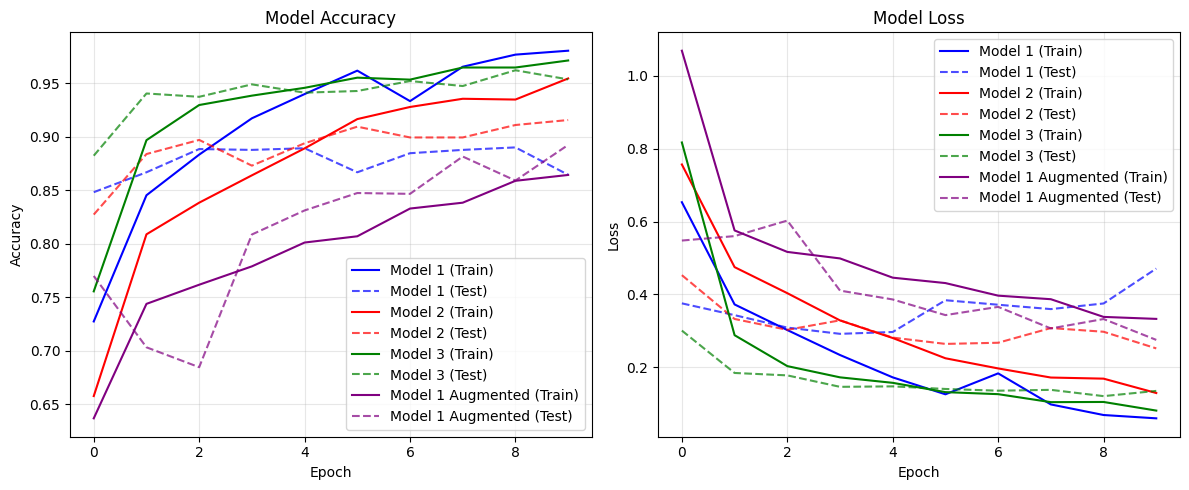

In [ ]:
# Create comparison plot
plt.figure(figsize=(12, 5))

# Define colors for each model
colors = {"Model 1": "blue", "Model 2": "red", "Model 3": "green", "Model 1 Augmented": "purple"}

# Plot accuracy
plt.subplot(1, 2, 1)
for hist, name in [
    (history1, "Model 1"),
    (history2, "Model 2"),
    (history3, "Model 3"),
    (history1_aug, "Model 1 Augmented"),
]:
    color = colors[name]
    plt.plot(hist.history["accuracy"], color=color, label=f"{name} (Train)")
    plt.plot(hist.history["val_accuracy"], color=color, linestyle="--", alpha=0.7, label=f"{name} (Test)")

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
for hist, name in [
    (history1, "Model 1"),
    (history2, "Model 2"),
    (history3, "Model 3"),
    (history1_aug, "Model 1 Augmented"),
]:
    color = colors[name]
    plt.plot(hist.history["loss"], color=color, label=f"{name} (Train)")
    plt.plot(hist.history["val_loss"], color=color, linestyle="--", alpha=0.7, label=f"{name} (Test)")

plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
models = ["Model 1", "Model 1 Augmented", "Model 2", "Model 3"]
accuracies = [
    history1.history["val_accuracy"][-1],
    history1_aug.history["val_accuracy"][-1],
    history2.history["val_accuracy"][-1],
    history3.history["val_accuracy"][-1],
]

for name, acc in zip(models, accuracies):
    print(f"{name} Test Accuracy: {acc * 100:.2f}%")

Model 1 Test Accuracy: 86.44%
Model 1 Augmented Test Accuracy: 89.23%
Model 2 Test Accuracy: 91.56%
Model 3 Test Accuracy: 95.35%


| **Model**                | **Test Accuracy** | **Key Features**                                         |
|--------------------------|-------------------|----------------------------------------------------------|
| Model 1 (Simple CNN)      | 86.44%            | Basic CNN with two convolutional layers                   |
| Model 1 Augmented         | 89.23%            | Data augmentation with rotation, zoom, and horizontal flip |
| Model 2 (Deeper CNN)      | 91.56%            | Deeper neural network with dropout for regularization      |
| Model 3 (VGG16 Transfer)  | 95.35%            | Pre-trained VGG16 model with custom fully connected layers |

### 7.2 Hyper-parameter Values for Successful Models

| Model | Optimizer | Learning Rate | Batch Size | Epochs | Dropout | Augmentation |
|---|---|---|---|---|---|---|
| Model 1 | Adam | Default (0.001) | 32 | 10 | None | None |
| Model 1 Augmented | Adam | Default (0.001) | 32 | 10 | None | rotation_range=5, zoom_range=0.1, horizontal_flip=True |
| Model 2 | Adam | Default (0.001) | 32 | 10 | 0.5 | None |
| Model 3 | Adam | Default (0.001) | 32 | 10 | 0.5 | None |

- **Model 3 (VGG16 Transfer Learning)** was the most successful, likely due to the depth and power of the pre-trained VGG16 architecture. The **learning rate** used was the default for the Adam optimizer (0.001), which worked well in this case. The **batch size** was set to 32, and **dropout** with a rate of 0.5 was added to the fully connected layer to prevent overfitting. The model was trained for **10 epochs**.

- **Model 2 (Deeper CNN)** also performed well, and the key hyper-parameters that contributed to its success were:
  - **Dropout** (0.5) to reduce overfitting.
  - **Batch size** (32) and **epochs** (10) were similar to Model 3, which suggests that the model was not underfitting or overfitting within the set training timeframe.

- **Data Augmentation** applied to Model 1 improved its test accuracy from 86.44% to 89.23%. This highlights the importance of adding variability to the training data, particularly when working with a smaller dataset or when the model is prone to overfitting.

## 8. Conclusion

- **Transfer Learning (Model 3)** provided the best results, achieving a test accuracy of **95.35%**, due to the feature extraction power of the pre-trained VGG16 model. This demonstrates the importance of leveraging pre-trained models, especially when working with relatively small datasets.

- **Deeper CNN (Model 2)**, with appropriate regularization, also performed well, achieving **91.56%** accuracy. This shows that increasing model complexity, when combined with regularization, can significantly improve performance over simpler models.

- **Data Augmentation** helped improve the performance of **Model 1**, indicating that it is a useful technique for improving model generalization, particularly when dealing with image data.
